# Advanced Feature Engineering for S&P 500 Forecasting Using Permutation Entropy and XGBoost

### Table of Contents

1. [Introduction](#1.-Introduction)

2. [Base Libraries](#2.-Base-Libraries)

3. [Data Loading and Preprocessing](#3.-Data-Loading-and-Preprocessing)

4. [Feature Engineering](#4.-Feature-Engineering)

5. [Model Training and Validation](#5.-Model-Training-and-Validation)

6. [Actual vs. Predicted](#6.-Actual-vs-Predicted)

7. [Conclusions](#7.-Conclusions)

8. [References](#8.-References)


# 1. Introduction

In the dynamic world of finance, the S&P 500 Index stands as a critical benchmark of the U.S. stock market's health, representing the performance of 500 large companies listed on stock exchanges in the United States. Forecasting its movements is an endeavor that financial analysts, traders, and economists have pursued for decades, aiming to gain a competitive edge in the market. While traditional methods have offered insights, the recent surge in computational power and advanced algorithms has opened up new avenues for predicting stock market indices with increased accuracy.

This notebook delves into one such modern approach, combining the strength of Permutation Entropy with the power of the XGBoost algorithm to forecast the S&P 500 Index. Permutation Entropy provides a measure of the complexity in time series data, capturing intricate patterns often missed by standard statistical methods. When paired with XGBoost, a gradient boosting algorithm renowned for its predictive capabilities, the results can be both insightful and precise. Through this analysis, we aim to demonstrate a robust method for time series forecasting, offering valuable insights into the future movements of the S&P 500 Index.



# 2. Base Libraries

In this notebook, several key Python libraries are utilized to facilitate the analysis. **numpy** (np) serves as the foundation for numerical operations, enabling efficient handling of arrays and mathematical functions. **pandas** (pd) is instrumental in data manipulation and analysis, providing flexible data structures like DataFrames that simplify the ingestion and processing of our dataset. For visualization, **matplotlib.pyplot** (plt) is employed, offering a range of plotting tools to effectively illustrate data trends and results. The **pyentrp** library, specifically the entropy module (referred to as ent), is essential for computing Permutation Entropy, which quantifies the complexity of time series data. The **train_test_split** function from sklearn.model_selection aids in segregating the dataset into training and test subsets, ensuring a robust evaluation of our model. Several metrics, including **mean_squared_error**, **mean_absolute_error**, and **r2_score** from sklearn.metrics, are utilized to gauge the model's performance and accuracy. Lastly, **xgboost** (xgb) is incorporated, a gradient boosting framework known for its powerful predictive capabilities, especially in the realm of regression and classification tasks.

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyentrp import entropy as ent
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

To measure the model's efficiency, three metrics were used:
* **Root Mean Squared Error (RMSE)**: quantifies the average magnitude of errors between predicted and observed values. Squared differences penalize larger errors, offering insight into the model's error spread.

* **Mean Absolute Error (MAE)**: averages the absolute differences between predicted and actual values. Provides a straightforward representation of the average error magnitude.

* **R-squared (Coefficient of Determination)**: shows the variance proportion in the dependent variable that's predictable from the independent variables. A value near 1 indicates the model explains most of the response variability in its predictions.

# 3. Data Loading and Preprocessing

In this data preprocessing step, the S&P 500 index data is loaded from a CSV file using pandas. The 'Date' column, initially read as a string, is converted to a datetime format for better time series handling. Subsequently, this 'Date' column is set as the index for the DataFrame, providing a time-ordered structure. Any rows with null or missing values are removed to ensure data consistency. Additionally, rows where the 'S&P500' column has a value of zero are excluded, as these could indicate potential data errors or missing entries. After these preprocessing steps, the first ten rows of the cleaned dataset are displayed to give an initial overview.

In [13]:
# Load the data and perform basic preprocessing
data = pd.read_csv('data/sp500_index.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Handle null values
data.dropna(inplace=True)

# Remove rows with zeros in 'S&P500' column as they might represent missing data or errors
data = data[data['S&P500'] != 0]

# Display the first few rows of the cleaned dataset
data.head(10)


,S&P500
Date,
2013-10-14,1710.14
2013-10-15,1698.06
2013-10-16,1721.54
2013-10-17,1733.15
2013-10-18,1744.50
2013-10-21,1744.66
2013-10-22,1754.67
2013-10-23,1746.38
2013-10-24,1752.07


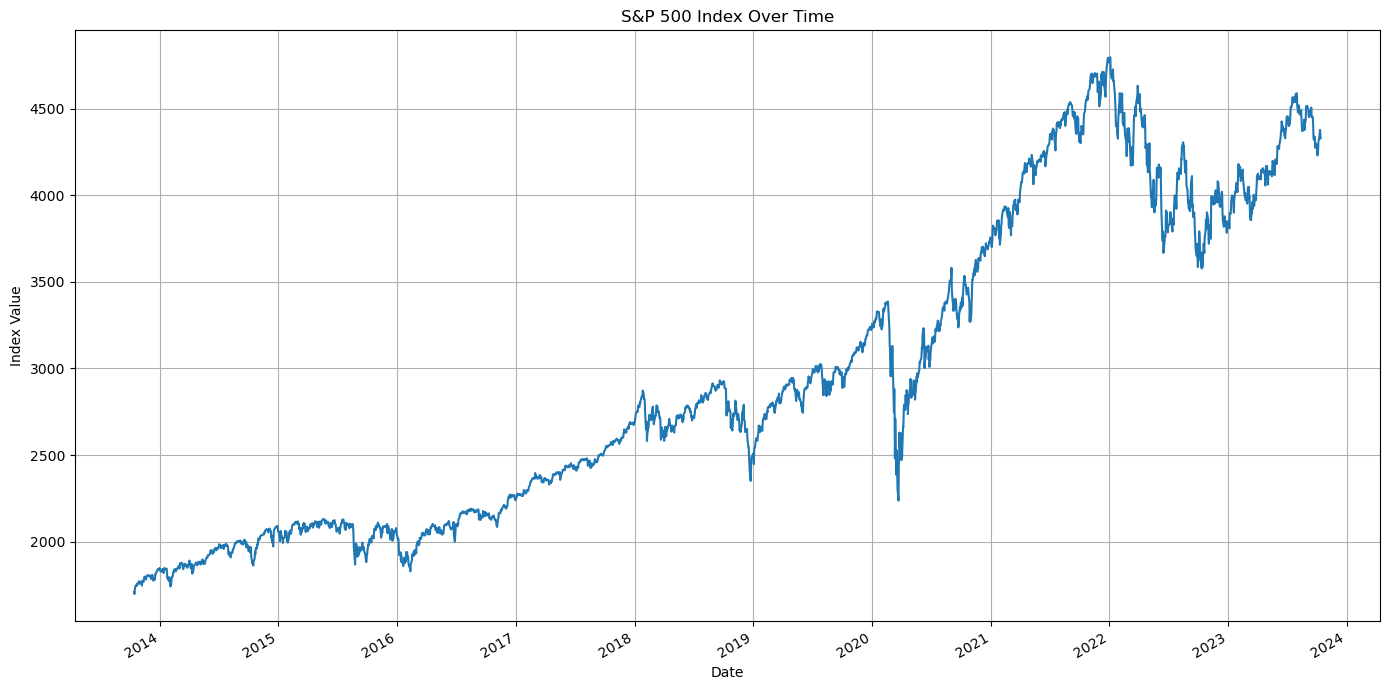

In [14]:
# Visualize the data
plt.figure(figsize=(14, 7))
data['S&P500'].plot(title='S&P 500 Index Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Feature Engineering

In [15]:
# Define the parameters for Permutation Entropy
m = 3
tau = 1

# Compute Permutation Entropy as features
def compute_pe(ts, m, tau):
    n = len(ts)
    pe_values = []
    for i in range(n - m * tau):
        window = ts[i:i + m * tau:tau]
        pe = ent.permutation_entropy(window, order=m, delay=tau)
        pe_values.append(pe)
    return pe_values

pe_features = compute_pe(data['S&P500'], m, tau)


In [16]:
# Compute Permutation Entropy as features
pe_features = compute_pe(data['S&P500'], m, tau)

# Add lagged values as features
lags = 5
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data['S&P500'].shift(i)

# Drop NaN rows introduced by lags
data = data.iloc[lags:]

# Ensure the length of pe_features matches the cleaned data
pe_features = pe_features[:len(data)]

# Create a DataFrame for features
features_df = pd.DataFrame({'PE': pe_features})
for i in range(1, lags + 1):
    features_df[f'lag_{i}'] = data[f'lag_{i}'].values


# 5. Model Training and Validation

In [17]:
# Prepare dataset for forecasting
X = features_df.values

# Adjust the target values 'y' to match the length of 'X'
y = data['S&P500'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
# Train the XGBoost model and compute metrics
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (Coefficient of Determination): {r2:.2f}")

Root Mean Squared Error (RMSE): 88.62
Mean Absolute Error (MAE): 63.82
R-squared (Coefficient of Determination): 0.91


# 6. Actual vs Predicted

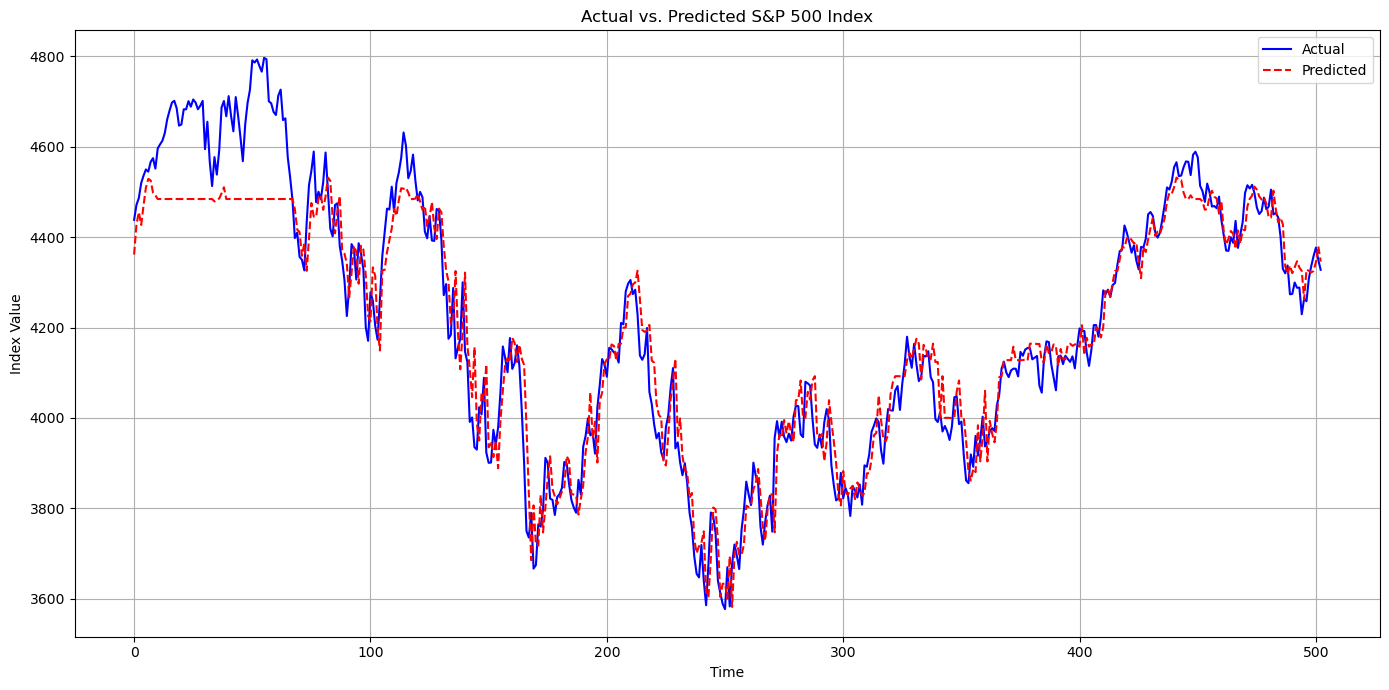

In [20]:
# Visualize actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted S&P 500 Index')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Conclusions

# 8. References